# Risiko Detection: Boxes Analisys #
Here we will analyze the properties of the bounding boxes specified as text files inside the directory specified as *labels_path*.

In [4]:
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import cv2
plt.rcParams['figure.figsize'] = [9, 9]

labels_path = "Professor_Material/real_images/labels"
images_path = "Professor_Material/real_images/images"

#### Read Data ####
Read labels files, compute areas and ratios and do some statistics

In [8]:
labels_files = sorted( filter( lambda x: os.path.isfile(os.path.join(labels_path, x)),os.listdir(labels_path) ) )
boxes = np.empty([0,4], dtype=np.float32)

labels_list = []
img_dims = []
for filename in labels_files:
    lbl = np.loadtxt(os.path.join(labels_path, filename), dtype=np.float32)

    img_path = os.path.join(images_path, os.path.splitext(filename)[0] + ".jpg")
    img = cv2.imread(img_path)
    #img_dim = np.array([img.shape[0], img.shape[1], img.shape[0], img.shape[1]], dtype=np.float32)
    img_dim = np.array([1920,1080,1920,1080], dtype=np.float32)

    np.multiply(lbl[:,1:], img_dim, out=lbl[:,1:])
    np.floor(lbl, out=lbl)

    img_dims.append(img_dim)
    labels_list.append(lbl)
    boxes = np.vstack([boxes, lbl[:,1:]], dtype=np.float32)

sizes = boxes[:,2:]
areas = np.sqrt(sizes[:,0] * sizes[:,1])
ratios = sizes[:,0] / sizes[:,1]

box_stat_data = np.hstack([sizes, areas.reshape([areas.shape[0],1]), ratios.reshape([ratios.shape[0],1])])

df = pd.DataFrame(box_stat_data)
df.columns = ["Width", "Height", "Area", "Ratio"]
df.describe()

Find Image with objects that have the smallest area to inspect it manually (check whether it's actually worth it to allow detection for such small objects)

In [20]:
min_dims = np.array([0, 1000, 1000, 1000], np.float32)
for i in range(len(labels_list)):
    inst_areas = labels_list[i][:,3] * labels_list[i][:,4]
    min_id = np.argmin(inst_areas)
    if inst_areas[min_id] < min_dims[1]:
        min_dims[0:] = i, inst_areas[min_id], labels_list[i][min_id,3] , labels_list[i][min_id,4]

print(min_dims) 
print(labels_files[int(min_dims[0])])

[15. 24.  8.  3.]
000019.txt


Now we check some statistics about the IoU in each image

In [ ]:
def IoU(boxes:np.ndarray, box:np.ndarray, nboxes:int) -> bool:
    x21, y21, x22, y22 = np.split(oldboxes[:nboxes-1], 4, axis=1)

    xA = np.maximum(newbox[0], np.transpose(x21))
    yA = np.maximum(newbox[1], np.transpose(y21))
    xB = np.minimum(newbox[2], np.transpose(x22))
    yB = np.minimum(newbox[3], np.transpose(y22))

    interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)

    boxAArea = (newbox[2] - newbox[0] + 1) * (newbox[3] - newbox[1] + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    unionArea = (boxAArea + boxBArea) - interArea

    IoU = interArea / unionArea

    return IoU



#### Plot all points ####

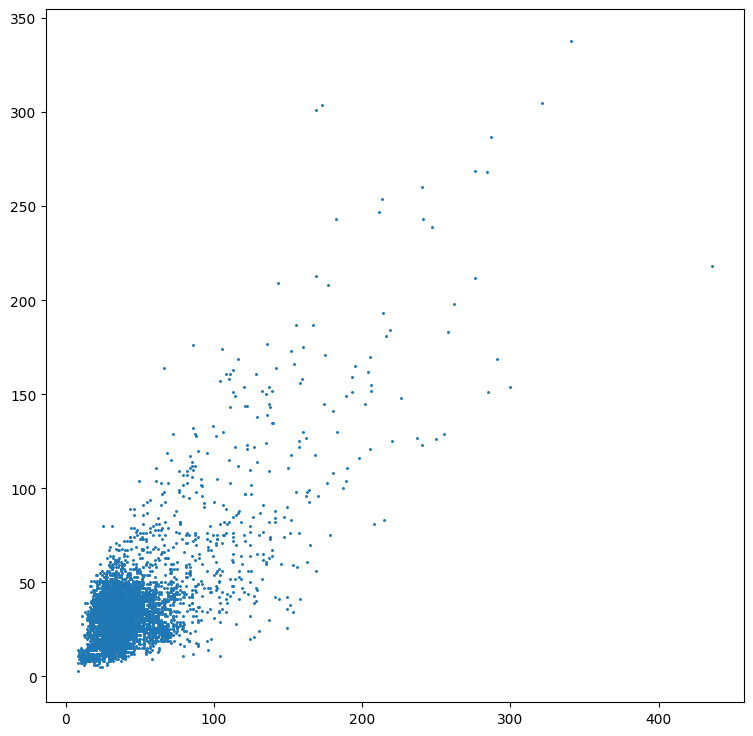

In [21]:
plt.scatter(sizes[:,0], sizes[:,1], s=5, marker='.')
plt.show()

Get histogram on areas to estimate size

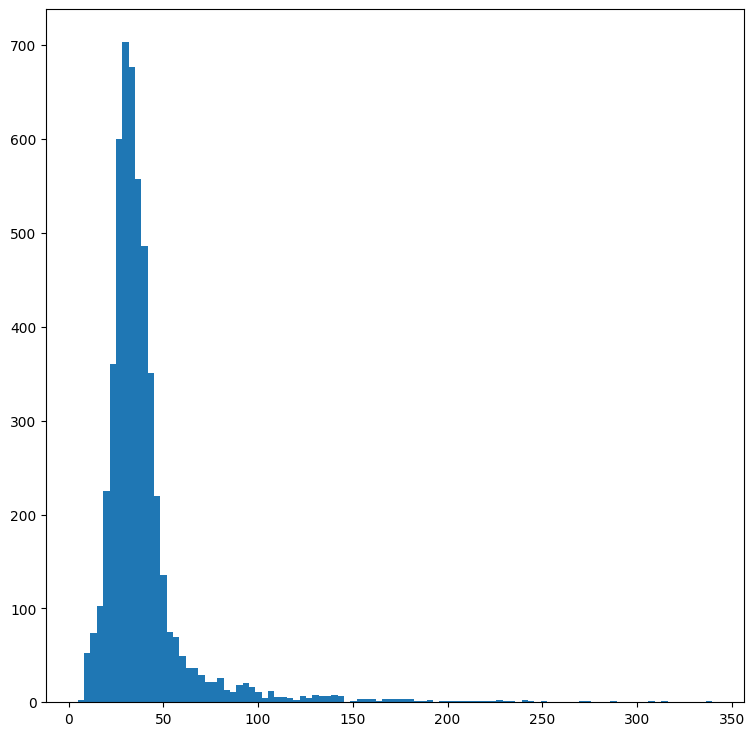

In [22]:
plt.hist(areas, bins=100)
plt.show()

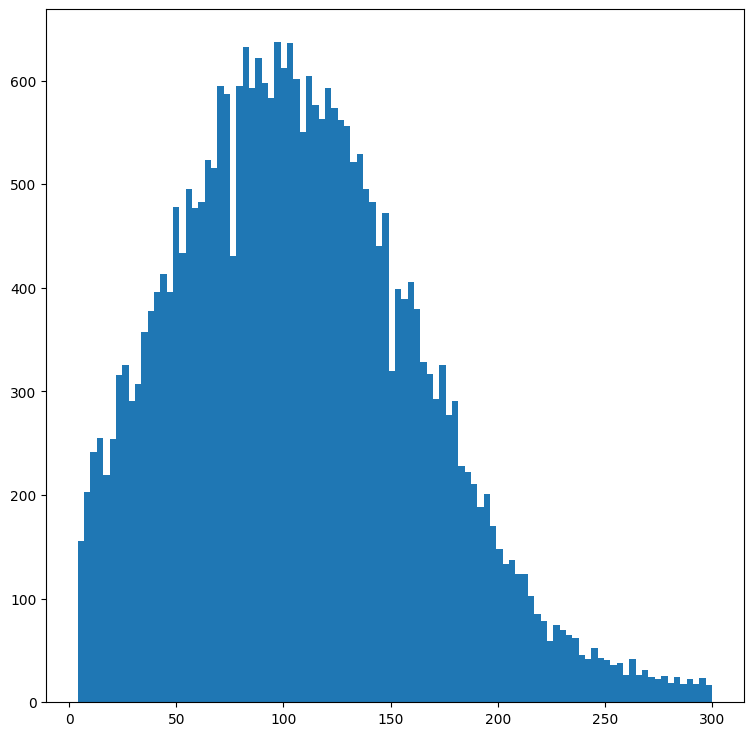

,Area
count,30000.000000
mean,108.629800
std,56.348936
min,4.000000
25%,67.000000
50%,104.000000
75%,145.000000
max,300.000000


In [23]:
mu, std = 100, 60
min_area, max_area = 
a = np.random.normal(mu, std, 30000).astype(np.int32)
mask = np.logical_or((a - 3) <= 0, a > 300)

alt_mu, alt_std = mu, std
while mask.any():
    alt_mu += 0
    alt_std += 150
    a[mask] = np.random.normal(alt_mu, alt_std, a[mask].shape[0]).astype(np.int32)
    np.logical_or((a - 3) <= 0, a > 300, out=mask)
    #print("mu=" + str(alt_mu) + "   std=" + str(alt_std))

plt.hist(a, 100)
plt.show()

descr = pd.DataFrame(a)
descr.columns = ["Area"]
descr.describe()

## KMeans Clustering ##
Now we run some clustering to identify patterns in the data. This will useful when generating the neural network model and detecting the tanks and flags.
In particular this results will be useful when chosing the anchor boxes size and ratios

#### Clustering plot function ####

In [ ]:
def plot_clusters(points:np.ndarray, labels:np.ndarray, k:int, centers=None):
    # plot the 3 clusters
    colors = ["green", "darkorange", "purple", "blue", "lightblue", "lightgreen"]
    for i in range(k):
        plt.scatter(points[labels == i, 0], points[labels == i, 1], s=5, c=colors[i], marker='.', label="cluster " + str(i))

    # plot the centroids
    if not (centers is None):
        plt.scatter(centers[:, 0], centers[:, 1], s=20, marker='o', c='red', edgecolor='black', label='centroids')

    plt.legend(scatterpoints=1)
    plt.minorticks_on()
    plt.xlim([0,points[:,0].max()+20])
    plt.ylim([0,points[:,1].max()+20])
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.show()

#### Clustering on Size ####

In [ ]:
k_sizes = 3
km_size = KMeans(n_clusters=k_sizes, n_init='auto')
km_sizes_output = km_size.fit_predict(sizes)
print(km_size.cluster_centers_.round())

plot_clusters(sizes, km_sizes_output, k_sizes, km_size.cluster_centers_)

#### Clustering on Ratios

In [ ]:
k_ratios = 3
km_ratios = KMeans(n_clusters=k_ratios, n_init='auto')
km_ratios_output = km_ratios.fit_predict(ratios.reshape(ratios.shape[0], 1))
print(km_size.cluster_centers_)

plot_clusters(sizes, km_ratios_output, k_ratios)

#### Some combination of the both clusterings ####
First we separtate the sets into the clusters identified by size clustering, then we run clustering on ratios on each subset

In [ ]:
sizes_subsets, ratios_subsets = [], []
for i in range(k_sizes):
    sizes_subsets.append(sizes[km_sizes_output == i])
    ratios_subsets.append(ratios[km_sizes_output == i])

k_ratios = 3
km_ratios = KMeans(n_clusters=k_ratios, n_init='auto')
for i in range(k_sizes):
    km_ratios_output = km_ratios.fit_predict(ratios_subsets[i].reshape(ratios_subsets[i].shape[0], 1))

    

    plot_clusters(sizes_subsets[i], km_ratios_output, k_ratios)
    

In [ ]:
print(km_ratios_output)